<a href="https://colab.research.google.com/github/Swethan-colab/Sonu27/blob/main/3Drnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd

path = "/content/drive/MyDrive/NLH.xlsx"
# Read the Excel file
df = pd.read_excel(path)

# Display the DataFrame
print(df)



     Unnamed: 0 Unnamed: 1  Unnamed: 2
0           NaN       epsn    sigmaiso
1           NaN    0.00005    2.592593
2           NaN    0.00055   28.518519
3           NaN    0.00105   54.444444
4           NaN    0.00155   62.387902
..          ...        ...         ...
356         NaN    0.01755  168.331045
357         NaN    0.01805  168.789461
358         NaN    0.01855  169.247876
359         NaN    0.01905  169.706291
360         NaN    0.01955  170.164706

[361 rows x 3 columns]


In [18]:
column_names = ['index', 'epsn', 'sigmaiso']  # Replace with your desired names
df.columns = column_names


# Assuming the column with NaN values is named 'Unnamed: 0'
df_ = df[['epsn', 'sigmaiso']]
df__ = df_.iloc[1:]
print(df__)

        epsn    sigmaiso
1    0.00005    2.592593
2    0.00055   28.518519
3    0.00105   54.444444
4    0.00155   62.387902
5    0.00205   64.874616
..       ...         ...
356  0.01755  168.331045
357  0.01805  168.789461
358  0.01855  169.247876
359  0.01905  169.706291
360  0.01955  170.164706

[360 rows x 2 columns]


In [36]:

import torch

# Assuming 'df__' is your DataFrame
# Check for missing values
if df__['sigmaiso'].isnull().any():
    print("Warning: 'sigmaiso' column contains missing values (NaNs).")
    # Choose a solution: remove rows, impute missing values, etc.
    df__ = df__.dropna(subset=['sigmaiso'])  # Example: Remove rows with NaNs in 'sigmaiso'

# Check data types and convert to numeric if needed
if not pd.api.types.is_numeric_dtype(df__['sigmaiso']):
    print("Warning: 'sigmaiso' column may contain non-numerical data types.")
    # Use .loc to safely modify the column
    df__.loc[:, 'sigmaiso'] = pd.to_numeric(df__['sigmaiso'], errors='coerce')

# Assuming data is now clean
y = torch.from_numpy(df__['sigmaiso'].values.astype(np.float32)).unsqueeze(1)  # Convert to float32 for PyTorch


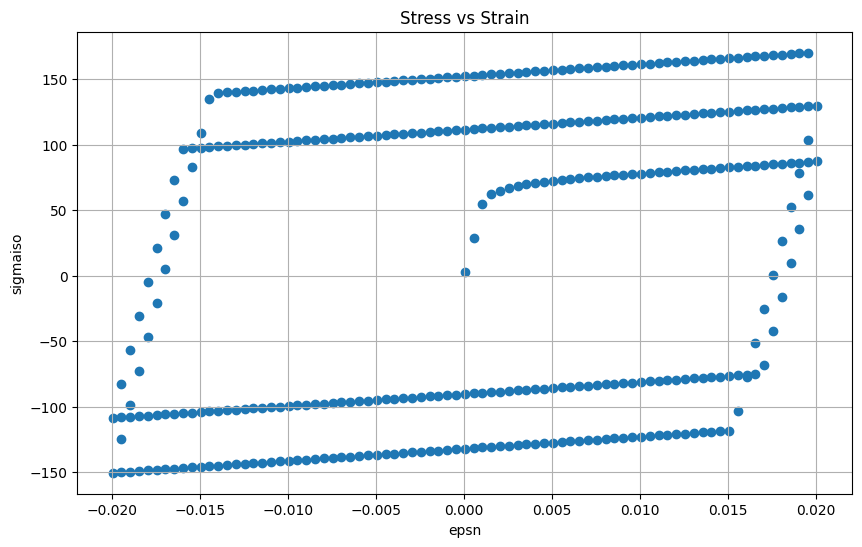

In [86]:
import matplotlib.pyplot as plt
#Datacorrection in espn values

if df__['epsn'].isnull().any():
    print("Warning: 'sigmaiso' column contains missing values (NaNs).")
    # Choose a solution: remove rows, impute missing values, etc.
    df__ = df__.dropna(subset=['epsn'])  # Example: Remove rows with NaNs in 'sigmaiso'

# Check data types and convert to numeric if needed
if not pd.api.types.is_numeric_dtype(df__['epsn']):
    print("Warning: 'epsn' column may contain non-numerical data types.")
    # Use .loc to safely modify the column
    df__.loc[:, 'epsn'] = pd.to_numeric(df__['epsn'], errors='coerce')

# Assuming data is now clean
x = torch.from_numpy(df__['epsn'].values.astype(np.float32)).unsqueeze(1)  # Convert to float32 for PyTorch

plt.figure(figsize=(10, 6))  # Set plot figure size

plt.scatter(x, y)  # Scatter plot for epsn vs sigmaiso
plt.xlabel('epsn')  # Label for x-axis
plt.ylabel('sigmaiso')  # Label for y-axis
plt.title('Stress vs Strain')  # Plot title

# Optional: Add gridlines for better readability
plt.grid(True)

# Show the plot
plt.show()


In [57]:

def normalize(data):
  """
  Normalizes data to a range of [0, 1].

  Args:
      data (torch.Tensor): The data to be normalized.

  Returns:
      torch.Tensor: The normalized data.
  """
  min_val = torch.min(data)
  max_val = torch.max(data)
  return (data - min_val) / (max_val - min_val)
def z_score(data):
  return (data - data.mean()) / data.std()

In [81]:
from sklearn.model_selection import train_test_split
X_train_val, X_test_, y_train_val, y_test_ = train_test_split(x, y, test_size=0.1, random_state=42)

# Further split training and validation sets (from X_train_val and y_train_val)
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_val, y_train_val, test_size=0.16, random_state=42)

X_train = normalize(X_train_)
X_val = normalize(X_val_)
X_test = normalize(X_test_)

y_train = normalize(y_train_)
y_val = normalize(y_val_)
y_test = normalize(y_test_)


In [75]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming 'x' and 'y' are your PyTorch tensors
train_dataset = TensorDataset((X_train), (y_train))
val_dataset = TensorDataset((X_val), (y_val))
test_dataset = TensorDataset((X_test), (y_test))
batch_size=32
# Create data loaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [76]:
epochs = 100
batch_size = 32
patience = 5  # Early stopping patience
learning_rate = 0.001

In [77]:
import torch.nn as nn

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.gru1 = nn.GRU(input_size=1, hidden_size=32)
    self.gru2 = nn.GRU(input_size=32, hidden_size=16)
    self.linear = nn.Linear(16, 1)

  def forward(self, x):
    x = self.gru1(x)[0]  # Access hidden state from GRU1
    x = self.gru2(x)[0]  # Access hidden state from GRU2
    x = self.linear(x)
    return x

# Create the model
model = MyModel()



# Function to calculate loss for a given data loader
def calculate_loss(data_loader, model, loss_fn):
  total_loss = 0
  for data, target in data_loader:
    predicted_stress = model(data)
    loss = loss_fn(predicted_stress, target)
    total_loss += loss.item()
  return total_loss / len(data_loader)

In [78]:


def evaluate(model, val_dataloader, criterion):
    model.eval()  # Set model to evaluation mode (optional for some layers)
    with torch.no_grad():
        total_val_loss = 0
        for data, target in val_dataloader:
            output = model(data)
            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()
    return total_val_loss / len(val_dataloader)

def train_model(model, train_loader, val_loader, epochs, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adjust optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss

    training_losses = []  # Store training losses for each epoch
    validation_losses = []  # Store validation losses for each epoch

    best_val_loss = float('inf')
    for epoch in range(epochs):
        # Train loop
        total_train_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()  # Reset gradients for each batch

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Calculate and print average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

        # Validation
        val_loss = evaluate(model, val_dataloader, criterion)
        validation_losses.append(val_loss)
        print(f"Val Loss: {val_loss:.4f}")

        # Early stopping (implementation not shown here for brevity)

    # Plot training and validation loss (after training)
    plt.plot(range(epochs), training_losses, label='Training Loss')
    plt.plot(range(epochs), validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Load best model weights (implementation not shown here for brevity)
    return model


Epoch 1/100, Train Loss: 0.2834
Val Loss: 0.2068
Epoch 2/100, Train Loss: 0.1728
Val Loss: 0.1420
Epoch 3/100, Train Loss: 0.1411
Val Loss: 0.1417
Epoch 4/100, Train Loss: 0.1507
Val Loss: 0.1376
Epoch 5/100, Train Loss: 0.1391
Val Loss: 0.1355
Epoch 6/100, Train Loss: 0.1343
Val Loss: 0.1345
Epoch 7/100, Train Loss: 0.1354
Val Loss: 0.1336
Epoch 8/100, Train Loss: 0.1307
Val Loss: 0.1327
Epoch 9/100, Train Loss: 0.1376
Val Loss: 0.1316
Epoch 10/100, Train Loss: 0.1394
Val Loss: 0.1306
Epoch 11/100, Train Loss: 0.1333
Val Loss: 0.1292
Epoch 12/100, Train Loss: 0.1301
Val Loss: 0.1282
Epoch 13/100, Train Loss: 0.1329
Val Loss: 0.1273
Epoch 14/100, Train Loss: 0.1327
Val Loss: 0.1261
Epoch 15/100, Train Loss: 0.1288
Val Loss: 0.1249
Epoch 16/100, Train Loss: 0.1309
Val Loss: 0.1238
Epoch 17/100, Train Loss: 0.1292
Val Loss: 0.1228
Epoch 18/100, Train Loss: 0.1283
Val Loss: 0.1217
Epoch 19/100, Train Loss: 0.1258
Val Loss: 0.1204
Epoch 20/100, Train Loss: 0.1258
Val Loss: 0.1192
Epoch 21/

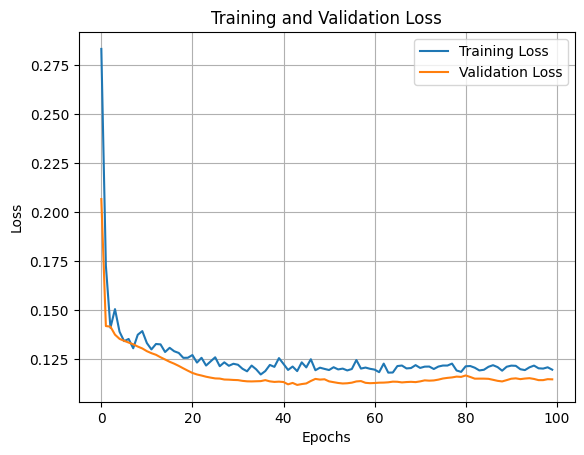

MyModel(
  (gru1): GRU(1, 32)
  (gru2): GRU(32, 16)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

In [80]:
train_model(model,train_dataloader,val_dataloader,epochs,patience)